In [1]:
using Gadfly
using Color
using Cairo
using Convex
using SCS
using ECOS
using PyCall
using PyPlot

INFO: Loading help data...


In [2]:
include("setup.jl")

combine (generic function with 1 method)

In [3]:
tract_data = readdlm("data/All_Tracts_FA.csv",',');
age_data = readdlm("data/Subject_Age.csv",',');

In [4]:
### sort the data by age
ord = sortperm(age_data[:,1]);
age_data = age_data[ord,1];

In [5]:
@pyimport seaborn as sns
sns.set()

In [10]:
length([1, 2, 3])

3

----------------------------------------------------------------------------
	SCS v1.0.7 - Splitting Conic Solver
	(c) Brendan O'Donoghue, Stanford University, 2012
----------------------------------------------------------------------------
Lin-sys: sparse-direct, nnz in A = 91161
eps = 1.00e-04, alpha = 1.80, max_iters = 10000, normalize = 0
Variables n = 15328, constraints m = 25462
Cones:	primal zero / dual free vars: 1
	linear vars: 20263
	soc vars: 5198, soc blks: 2
Setup time: 4.77e-02s
----------------------------------------------------------------------------
 Iter | pri res | dua res | rel gap | pri obj | dua obj | kap/tau | time (s)
----------------------------------------------------------------------------
     0|      inf       inf       nan      -inf       inf       inf  4.73e-03 
   100| 5.93e-04  1.15e-02  4.13e-04  1.13e+00  1.13e+00  1.04e-16  2.16e-01 
   200| 2.42e-04  2.90e-03  1.26e-04  1.19e+00  1.19e+00  1.08e-16  9.44e-01 
   300| 1.49e-04  1.96e-03  7.18e-05

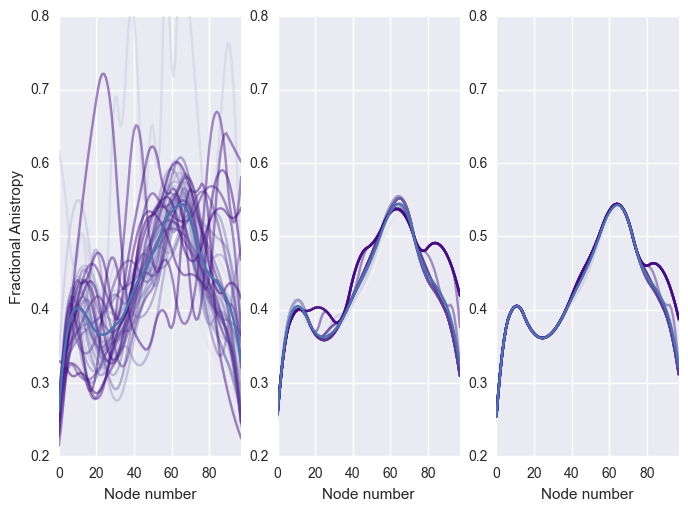

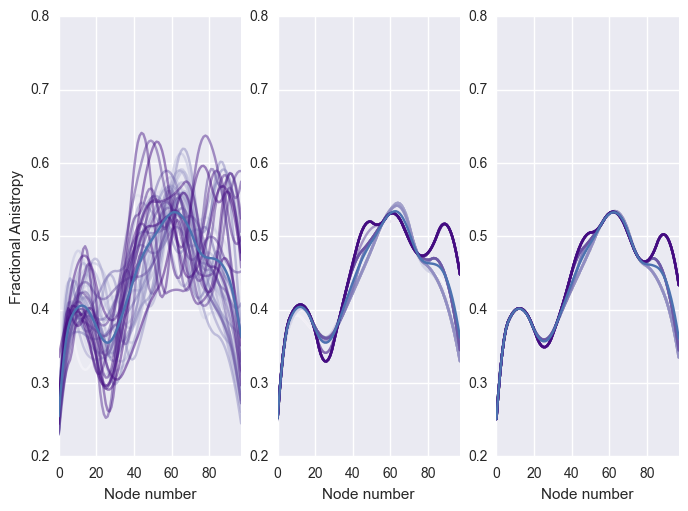

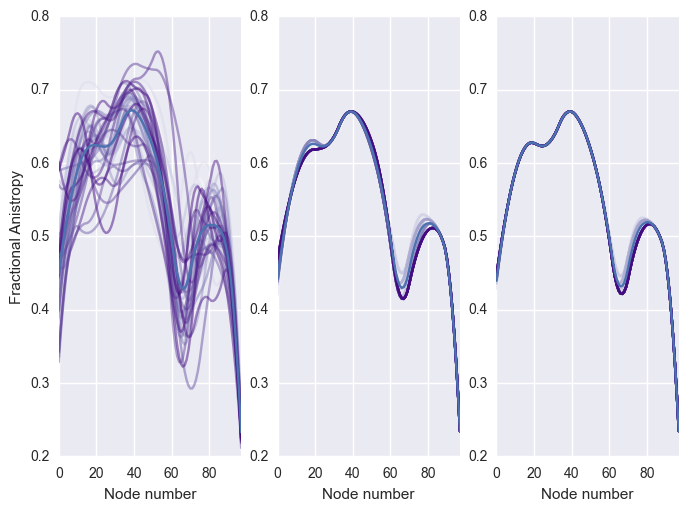

In [15]:
for tract_num = 1:3
    ## Removes the first and final tract values for each person & removes any people with NaN values
    X = tract_data[ord,(2:99) + 100*(tract_num-1)]
    keep = find(hasNaN(X).!=1)
    X = X[keep,:]; age = age_data[keep,1];

    junk = combine(age, X); age = junk["age"]; w = junk["w"]; X = junk["X"];  ## Combines people with identical ages, and computes an “average tract” over each unique age

    (n, p) = size(X)
    #lam1 = 0.3; lam2s = [0.0,0.1,0.2,0.3,0.4,0.5,0.6,0.7,0.8,0.9] ## lam1 is regularization param for smoothing, lam2 is regularization param for smoothing fits together
    lam1 = 0.3; lam2s = [0.0, 0.5, 0.9] ## lam1 is regularization param for smoothing, lam2 is regularization param for smoothing fits together
    D_a1 = form_D(n); D_age = DxInv(age,1); D_a2 = form_D(n-1);
    D0 = D_a1; #D_a2 * D_age * D_a1
    D1 = form_D(p); D2 = form_D(p-1); D3 = form_D(p-2);
    D = D3 * D2 * D1;

    fits = [fitter_group(X, w, D, D0, lam1, lam2) for lam2 in lam2s];
    figure()
    for i=1:length(lam2s)
        subplot(1, length(lam2s), i)
        sns.tsplot(fits[i]', err_style="unit_traces", err_palette=sns.color_palette("Purples", size(fits[i], 2)))
        ylim([0.2, 0.8])
        xlabel("Node number")    
    end
    subplot(1, length(lam2s), 1)
    ylabel("Fractional Anistropy")
end
